In [1]:
## Standard libraries
import os
import json
import math
import numpy as np
from typing import Any, Sequence
import pickle
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_13391/2159690685.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial3_jax"

# Verifying the device that will be used throughout this notebook
print("Device:", jax.devices()[0])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Device: METAL:0


2024-04-17 12:14:59.585853: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial3/"
# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please contact the author with the full output including the following error:\n", e)

In [5]:
#############################

class Sigmoid(nn.Module):

    def __call__(self, x):
        return 1 / (1 + jnp.exp(-x))

##############################

class Tanh(nn.Module):

    def __call__(self, x):
        x_exp, neg_x_exp = jnp.exp(x), jnp.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

##############################

In [6]:
##############################

class ReLU(nn.Module):

    def __call__(self, x):
        return jnp.maximum(x, 0)

##############################

class LeakyReLU(nn.Module):
    alpha : float = 0.1

    def __call__(self, x):
        return jnp.where(x > 0, x, self.alpha * x)

##############################

class ELU(nn.Module):

    def __call__(self, x):
        return jnp.where(x > 0, x, jnp.exp(x)-1)

##############################

class Swish(nn.Module):

    def __call__(self, x):
        return x * nn.sigmoid(x)

##############################

In [7]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

In [8]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An module or function of the forward pass of the activation function.
        x - 1D input array.
    Output:
        An array with the same size of x containing the gradients of act_fn at x.
    """
    return jax.vmap(jax.grad(act_fn))(x)

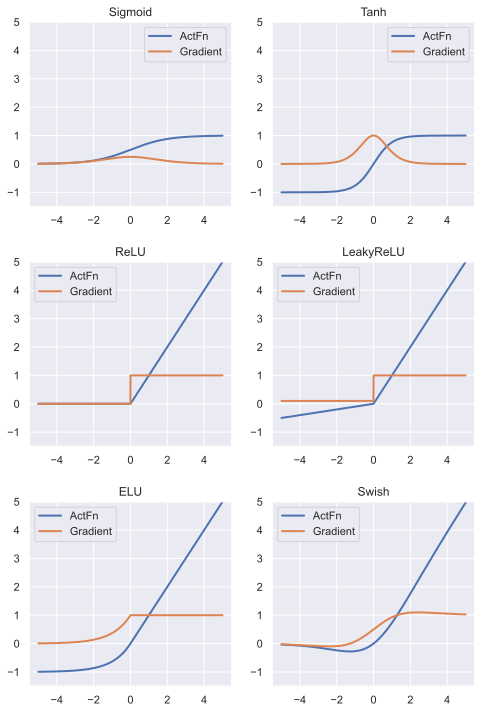

In [9]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    # x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.__class__.__name__)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = np.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()


In [10]:
# To keep the results close to the PyTorch tutorial, we use the same init function as PyTorch
# which is uniform(-1/sqrt(in_features), 1/sqrt(in_features)) - similar to He et al./kaiming
# The default for Flax is lecun_normal (i.e., half the variance of He) and zeros for bias.
init_func = lambda x: (lambda rng, shape, dtype: random.uniform(rng,
                                                                shape=shape,
                                                                minval=-1/np.sqrt(x.shape[1]),
                                                                maxval=1/np.sqrt(x.shape[1]),
                                                                dtype=dtype))

# Network
class BaseNetwork(nn.Module):
    act_fn : nn.Module
    num_classes : int = 10
    hidden_sizes : Sequence = (512, 256, 256, 128)

    @nn.compact
    def __call__(self, x, return_activations=False):
        x = x.reshape(x.shape[0], -1) # Reshape images to a flat vector
        # We collect all activations throughout the network for later visualizations
        # Remember that in jitted functions, unused tensors will anyways be removed.
        activations = []
        for hd in self.hidden_sizes:
            x = nn.Dense(hd,
                         kernel_init=init_func(x),
                         bias_init=init_func(x))(x)
            activations.append(x)
            x = self.act_fn(x)
            activations.append(x)
        x = nn.Dense(self.num_classes,
                     kernel_init=init_func(x),
                     bias_init=init_func(x))(x)
        return x if not return_activations else (x, activations)

In [11]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, state=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        state - (Optional) If given, the parameters are loaded into this training state. Otherwise,
                a new one is created alongside a network architecture.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if state is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
        state = train_state.TrainState(step=0,
                                       params=None,
                                       apply_fn=net.apply,
                                       tx=None,
                                       opt_state=None)
    else:
        net = None
    # You can also use flax's checkpoint package. To show an alternative,
    # you can instead load the parameters simply from a pickle file.
    with open(model_file, 'rb') as f:
        params = pickle.load(f)
    state = state.replace(params=params)
    return state, net

def save_model(model, params, model_path, model_name):
    """
    Given a model, we save the parameters and hyperparameters.

    Inputs:
        model - Network object without parameters
        params - Parameters to save of the model
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = {
        'num_classes': model.num_classes,
        'hidden_sizes': model.hidden_sizes,
        'act_fn': {'name': model.act_fn.__class__.__name__.lower()}
    }
    if hasattr(model.act_fn, 'alpha'):
        config_dict['act_fn']['alpha'] = model.act_fn.alpha
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    # You can also use flax's checkpoint package. To show an alternative,
    # you can instead save the parameters simply in a pickle file.
    with open(model_file, 'wb') as f:
        pickle.dump(params, f)

In [12]:
import torch
import torch.utils.data as data
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => bring them into a numpy array and normalize between -1 and 1
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - 0.5) / 0.5
    return img

# We need to stack the batch elements as numpy arrays
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH,
                             train=True,
                             transform=image_to_numpy,
                             download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                   [50000, 10000],
                                                   generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH,
                        train=False,
                        transform=image_to_numpy,
                        download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
val_loader   = data.DataLoader(val_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
test_loader  = data.DataLoader(test_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)

100%|██████████| 26421880/26421880 [00:02<00:00, 11322122.27it/s]


Extracting ../../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 2946444.90it/s]

Extracting ../../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 11136352.78it/s]


Extracting ../../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16457528.20it/s]


Extracting ../../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw



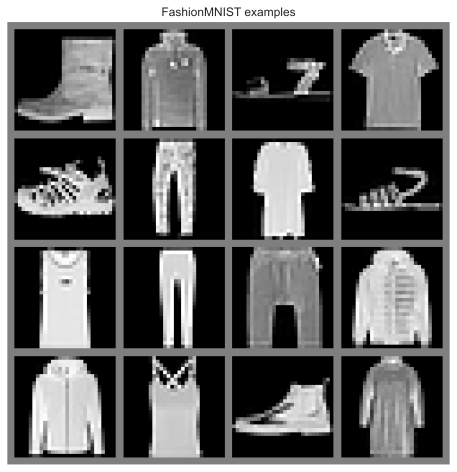

In [13]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.from_numpy(np.stack(exmp_imgs, axis=0))[:,None],
                                       nrow=4,
                                       normalize=True,
                                       pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [14]:
small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, collate_fn=numpy_collate)
exmp_batch = next(iter(small_loader))

In [15]:
def visualize_gradients(net, params, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    # Pass one batch through the network, and calculate the gradients for the weights
    def loss_func(p):
        imgs, labels = exmp_batch
        logits = net.apply(p, imgs)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
        return loss
    grads = jax.grad(loss_func)(params)
    grads = jax.device_get(grads)
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = jax.tree_util.tree_leaves(grads)
    grads = [g.reshape(-1) for g in grads if len(g.shape) > 1]

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for g_idx, g in enumerate(grads):
        key = f'Layer {g_idx * 2} - weights'
        key_ax = ax[g_idx%columns]
        sns.histplot(data=g, bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.act_fn.__class__.__name__}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

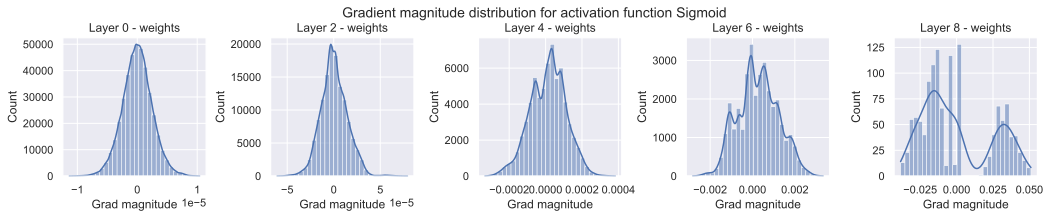

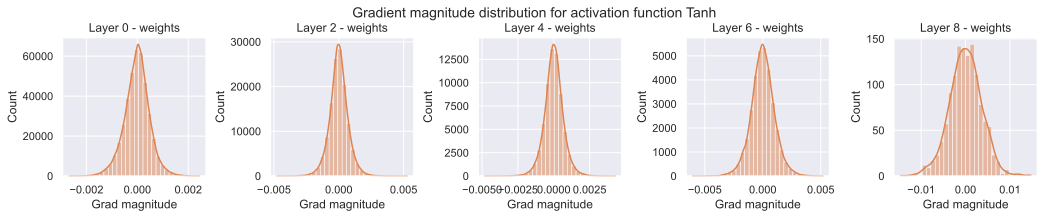

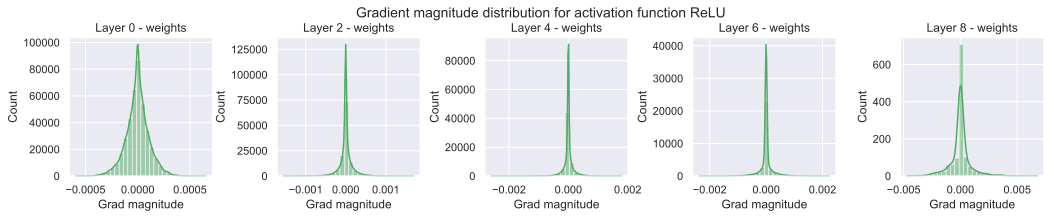

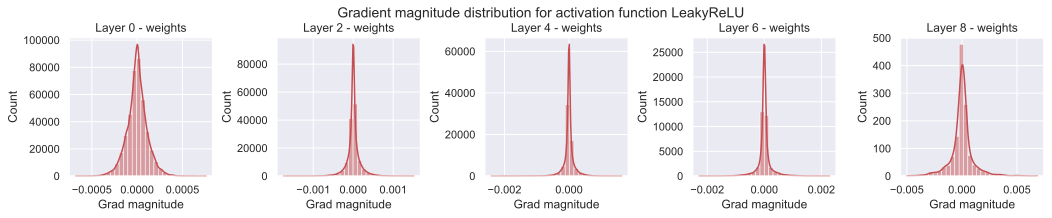

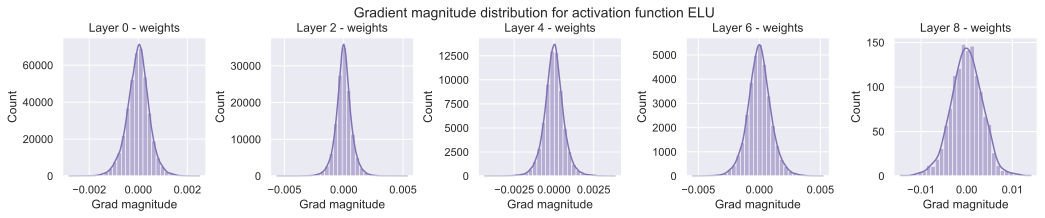

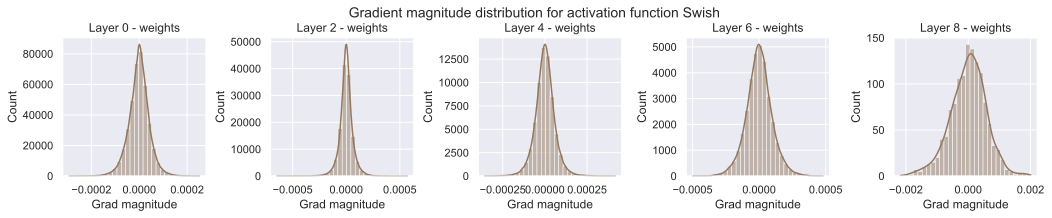

In [16]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn)
    params = net_actfn.init(random.PRNGKey(0), exmp_batch[0])
    visualize_gradients(net_actfn, params, color=f"C{i}")

In [19]:
def calculate_loss(params, apply_fn, batch):
    imgs, labels = batch
    logits = apply_fn(params, imgs)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    acc = (labels == logits.argmax(axis=-1)).mean()
    return loss, acc

@jax.jit
def train_step(state, batch):
    grad_fn = jax.value_and_grad(calculate_loss,
                                 has_aux=True)
    (_, acc), grads = grad_fn(state.params, state.apply_fn, batch)
    state = state.apply_gradients(grads=grads)
    return state, acc

@jax.jit
def eval_step(state, batch):
    _, acc = calculate_loss(state.params, state.apply_fn, batch)
    return acc

In [20]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
        state = None
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Initializing parameters and training state
        params = net.init(random.PRNGKey(42), exmp_batch[0])
        state = train_state.TrainState.create(apply_fn=net.apply,
                                              params=params,
                                              tx=optax.sgd(learning_rate=1e-2,
                                                           momentum=0.9))

        # Defining data loader
        train_loader_local = data.DataLoader(train_set,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             drop_last=True,
                                             collate_fn=numpy_collate,
                                             generator=torch.Generator().manual_seed(42))

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            train_acc = 0.
            for batch in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                state, acc = train_step(state, batch)
                train_acc += acc
            train_acc /= len(train_loader_local)

            ##############
            # Validation #
            ##############
            val_acc = test_model(state, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc:05.2%}, Validation accuracy: {val_acc:4.2%}")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, state.params, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    state, _ = load_model(CHECKPOINT_PATH, model_name, state=state)
    test_acc = test_model(state, test_loader)
    print((f" Test accuracy: {test_acc:4.2%} ").center(50, "=")+"\n")
    return state, test_acc


def test_model(state, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        state - Training state including parameters and model apply function.
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    true_preds, count = 0., 0
    for batch in data_loader:
        acc = eval_step(state, batch)
        batch_size = batch[0].shape[0]
        true_preds += acc * batch_size
        count += batch_size
    test_acc = true_preds / count
    return test_acc

In [21]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 78.46% ==============

Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.57% ==============

Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.65% ==============

Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.33% ==============

Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.32% ==============

Training BaseNetwork with swish activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.33% ==============



In [22]:
def visualize_activations(net, color="C0"):
    activations = {}

    imgs, labels = exmp_batch
    _, activations = net(imgs, return_activations=True)

    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    act_fn_name = net.act_fn.__class__.__name__
    for idx, activ in enumerate(activations):
        key_ax = ax[idx//columns][idx%columns]
        sns.histplot(data=activ.reshape(-1), bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {idx} - {'Dense' if idx%2==0 else act_fn_name}")
    fig.suptitle(f"Activation distribution for activation function {act_fn_name}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

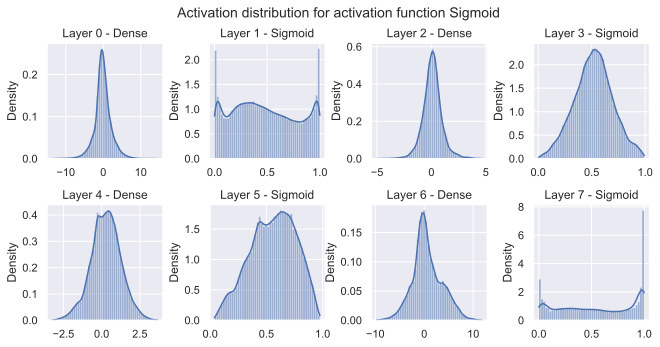

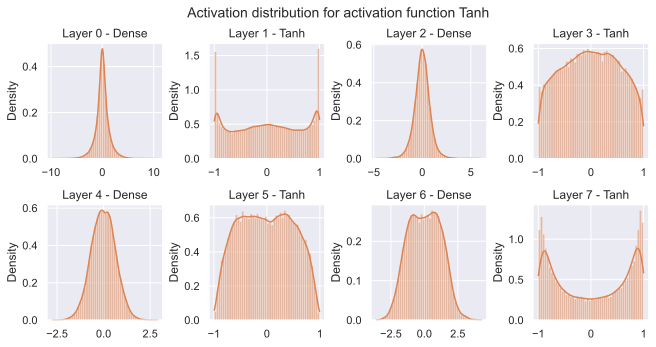

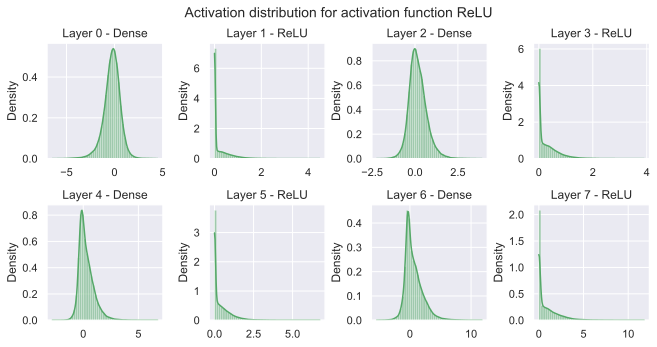

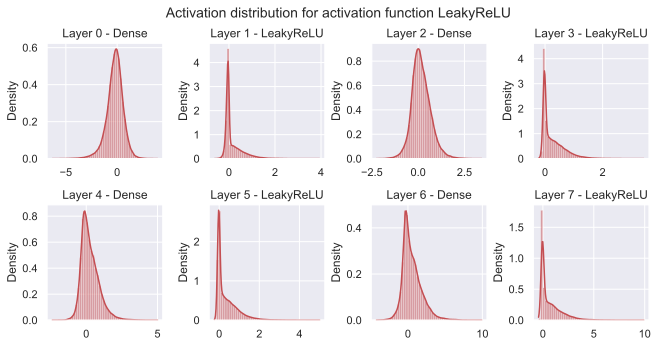

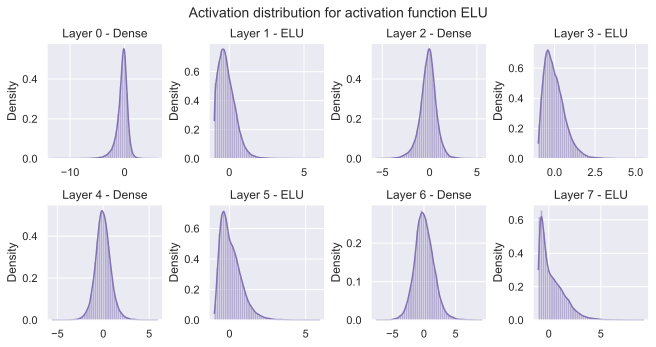

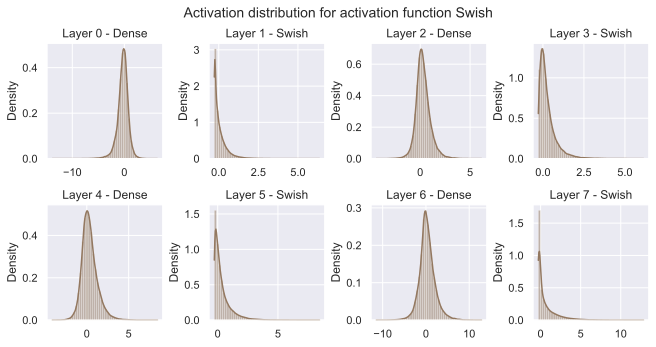

In [23]:
for i, act_fn_name in enumerate(act_fn_by_name):
    state, net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}")
    net_actfn = net_actfn.bind(state.params)
    visualize_activations(net_actfn, color=f"C{i}")

In [24]:
def measure_number_dead_neurons(net, params):
    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        jnp.ones(hd, dtype=jnp.dtype('bool')) for hd in net.hidden_sizes
    ] # Same shapes as hidden size in BaseNetwork

    get_activations = jax.jit(lambda inp: net.apply(params, inp, return_activations=True)[1])
    for imgs, _ in tqdm(train_loader, leave=False): # Run through whole training set
        activations = get_activations(imgs)
        for layer_index, activ in enumerate(activations[1::2]):
            # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
            neurons_dead[layer_index] = jnp.logical_and(neurons_dead[layer_index], (activ == 0).all(axis=0))
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{num_dead / tens.shape[0]:4.2%}" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

In [25]:
net_relu = BaseNetwork(act_fn=ReLU())
params = net_relu.init(random.PRNGKey(42), exmp_batch[0])
measure_number_dead_neurons(net_relu, params)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 1, 1, 10]
In percentage: 0.00%, 0.39%, 0.39%, 7.81%


In [26]:
state, net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu")
measure_number_dead_neurons(net_relu, state.params)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 3]
In percentage: 0.00%, 0.00%, 1.17%, 2.34%


In [27]:
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128])
params = net_relu.init(random.PRNGKey(42), exmp_batch[0])
measure_number_dead_neurons(net_relu, params)


  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 1, 3, 34, 76, 60, 69, 64, 63, 60]
In percentage: 0.00%, 0.39%, 1.17%, 13.28%, 29.69%, 46.88%, 53.91%, 50.00%, 49.22%, 46.88%
